### Descrição do Problema
As transações financeiras online cresceram exponencialmente nos últimos anos, trazendo consigo o aumento de fraudes e atividades suspeitas. Fintechs, bancos digitais e plataformas de pagamento enfrentam diariamente o desafio de identificar e bloquear transações fraudulentas em tempo real, sem impactar a experiência dos usuários legítimos.

Este projeto tem como objetivo desenvolver um modelo de machine learning capaz de identificar transações potencialmente fraudulentas, utilizando um conjunto de dados realista com mais de 51.000 registros. Cada transação é rotulada como fraudulenta ou legítima e acompanhada de informações relevantes como:

* Detalhes da transação: valor, tipo (saque, transferência, pagamento), horário

* Perfil do usuário: histórico de fraudes, idade da conta, número de transações recentes

* Contexto do dispositivo e localização: tipo de dispositivo usado e local da transação

* Método de pagamento utilizado

O principal desafio é ensinar o modelo a identificar padrões sutis de comportamento fraudulento, buscando o equilíbrio entre reduzir falsos positivos (evitar bloquear usuários legítimos) e aumentar a sensibilidade do modelo para capturar fraudes reais com precisão.

### Carregando Bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , classification_report, f1_score, precision_score, recall_score

### Carregando o conjunto de dados

In [2]:
# Carregando conjunto de dados
df = pd.read_csv('../data/Fraud Detection Dataset.csv')

# Pré-visualizando o conjunto de dados
df.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent
0,T1,4174,1292.76,ATM Withdrawal,16.0,Tablet,San Francisco,0,119,13,Debit Card,0
1,T2,4507,1554.58,ATM Withdrawal,13.0,Mobile,New York,4,79,3,Credit Card,0
2,T3,1860,2395.02,ATM Withdrawal,NaN,Mobile,NaN,3,115,9,NaN,0
3,T4,2294,100.10,Bill Payment,15.0,Desktop,Chicago,4,3,4,UPI,0
4,T5,2130,1490.50,POS Payment,19.0,Mobile,San Francisco,2,57,7,Credit Card,0


In [3]:
# Visualizando tipos de dados
df.dtypes

Transaction_ID                       object
User_ID                               int64
Transaction_Amount                  float64
Transaction_Type                     object
Time_of_Transaction                 float64
Device_Used                          object
Location                             object
Previous_Fraudulent_Transactions      int64
Account_Age                           int64
Number_of_Transactions_Last_24H       int64
Payment_Method                       object
Fraudulent                            int64
dtype: object

In [4]:
# Conhecendo o conjunto de dados
print('Visualizando quantidade de linhas do conjunto de dados:', df.shape[0])
print('Visualizando quantidade de colunas do conjunto de dados:', df.shape[1])

Visualizando quantidade de linhas do conjunto de dados: 51000
Visualizando quantidade de colunas do conjunto de dados: 12


#### Observações

* O conjunto de dados possuí um total de 51000 linhas e 12 colunas
* O conjunto também possuí um total de 7 colunas numéricas
* O conjunto também possuí 5 colunas object

### Verificando Valores Ausentes

In [5]:
df.isnull().sum()

Transaction_ID                         0
User_ID                                0
Transaction_Amount                  2520
Transaction_Type                       0
Time_of_Transaction                 2552
Device_Used                         2473
Location                            2547
Previous_Fraudulent_Transactions       0
Account_Age                            0
Number_of_Transactions_Last_24H        0
Payment_Method                      2469
Fraudulent                             0
dtype: int64

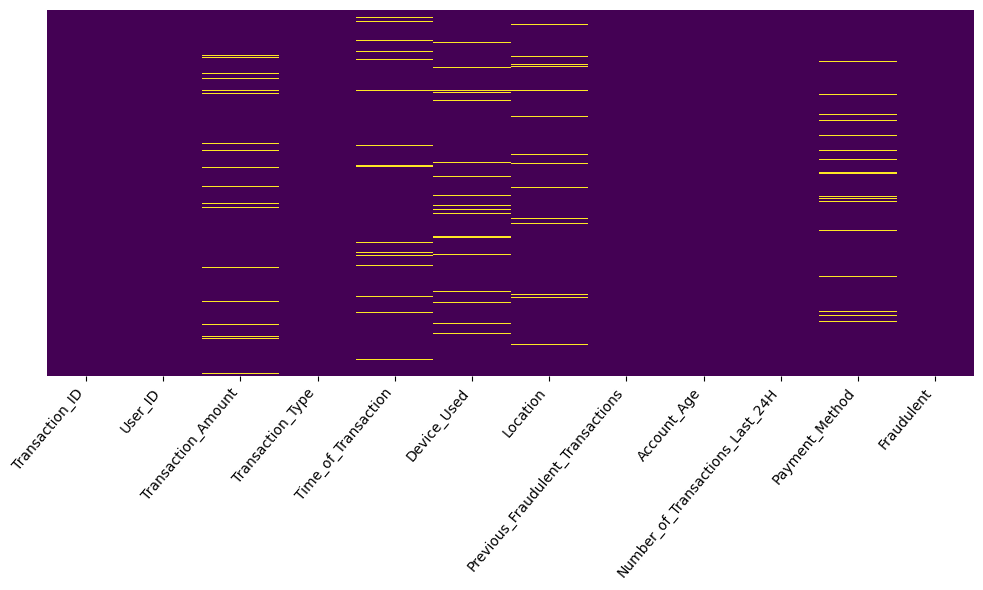

In [6]:
# Heatmap para valores ausentes

# Definindo tamanho da figura
plt.figure(figsize=(10,6))

# Plotando mapa de calor para valores ausentes
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')

# Ajustando os rótulos do eixo X para espaçamento uniforme
plt.xticks(rotation = 50, ha= 'right')
plt.tight_layout()

# Exibindo gráfico
plt.show()

In [9]:
# Checando os percentuais de valores ausentes
print(df['Transaction_Amount'].isnull().sum()/df.shape[0]*100)
print(df['Time_of_Transaction'].isnull().sum()/df.shape[0]*100)
print(df['Device_Used'].isnull().sum()/df.shape[0]*100)
print(df['Location'].isnull().sum()/df.shape[0]*100)
print(df['Payment_Method'].isnull().sum()/df.shape[0]*100)

4.941176470588235
5.003921568627451
4.849019607843137
4.9941176470588236
4.841176470588236


#### Observações

* O dataframe possuí 5 colunas com valores ausentes 
* Sendo 3 colunas categóricas(Device_Used, Location, Payment_Method) e 2 numéricas(Time_of_Transaction, Transaction_Amount)
* Como não houve uma ausêcia muito grande dos dados e são dados de registros não exclusivos farei o tratamento desses valores ausentes para as variáveis categóricas(Device_Used, Location, Payment_Method) usarei a moda e par a variáveil numérica Time_of_Transaction a moda e Transaction_Amount a mediana